# Проект QA

## Yes/No Questions

Вы будете работать с корпусом BoolQ. Корпус состоит из вопросов, предполагающих бинарный ответ (да / нет), абзацев из Википедии,  содержащих ответ на вопрос, заголовка статьи, из которой извлечен абзац и непосредственно ответа (true / false).

Корпус описан в статье:

Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, Kristina Toutanova
BoolQ: Exploring the Surprising Difficulty of Natural Yes/No Questions

https://arxiv.org/abs/1905.10044


Корпус (train-dev split) доступен в репозитории проекта:  https://github.com/google-research-datasets/boolean-questions

Используйте для обучения train часть корпуса, для валидации и тестирования – dev часть. 

Каждый бонус пункт оцениватся в 1 балл. Вывод являяется обязательным!

In [ ]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl ./

Copying gs://boolq/train.jsonl...
/ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


In [ ]:
train_path = "./train.jsonl"
dev_path = "./dev.jsonl"

In [ ]:
!pip install transformers

In [ ]:
import random
import torch
from torch import nn
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import transformers as ppb

import re

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from torch.utils.data import Dataset, random_split, Subset, DataLoader, Sampler

import torch.optim as optim

import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline
from IPython.display import clear_output

import gc

import json
import os
import nltk
import torch

from torchtext.legacy import data
from torchtext.legacy import datasets
from torchtext.vocab import GloVe


from nltk.tokenize.stanford import StanfordTokenizer

import torch.nn as nn
import torch.nn.functional as F


from dataclasses import dataclass, field

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# зафиксируем рандомы для воспроизводимости результатов

random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

In [ ]:
train_data_df = pd.read_json("train.jsonl", lines=True, orient='records')
dev_data_df = pd.read_json("dev.jsonl", lines=True, orient="records")

passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = train_data_df.answer.values.astype(int)

passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = dev_data_df.answer.values.astype(int)

In [ ]:
questions_dev[-5:]

array(['is manic depression the same as bi polar',
       'was whiskey galore based on a true story',
       'are there plants on the international space station',
       'does the hockey puck have to cross the line to be a goal',
       'will there be a season 5 of shadowhunters'], dtype=object)

Для проверки моделей приготовим тестовыe примеры.

In [ ]:
test_passages = passages_dev[-5:]
test_questions = questions_dev[-5:]
test_answers = answers_dev[-5:]

### Пример вопроса: 
question: is batman and robin a sequel to batman forever

title: Batman & Robin (film)

answer: true

passage: With the box office success of Batman Forever in June 1995, Warner Bros. immediately commissioned a sequel. They hired director Joel Schumacher and writer Akiva Goldsman to reprise their duties the following August, and decided it was best to fast track production for a June 1997 target release date, which is a break from the usual 3-year gap between films. Schumacher wanted to homage both the broad camp style of the 1960s television series and the work of Dick Sprang. The storyline of Batman & Robin was conceived by Schumacher and Goldsman during pre-production on A Time to Kill. Portions of Mr. Freeze's back-story were based on the Batman: The Animated Series episode ''Heart of Ice'', written by Paul Dini.

## Часть 4. Обучаем BERT на конкатенации вопроса и предложения (2 балла)

В этой части предлагается реализовать фреймворк, описанный в [видео по ссылке](https://www.youtube.com/watch?v=l8ZYCvgGu0o), адаптировав его под бинарный Question Answering. 

1. Опишите модель, которую вы будете реализовывать. Загрузите предобученный BERT, добавьте полносвязные "головные" слои. Дообучите модель: попробуйте разные способы обучения.

[bonus] Используйте модель [RoBERTa](https://arxiv.org/abs/1907.11692) вместо модели BERT. Посмотрите, что получилось.

Подготовим датасет, итераторы.

In [ ]:
class QADataset2(Dataset):
    def __init__(self, passages, questions, answers, tokenizer):
        self.labels = answers
        # tokenization
        self.texts = pd.Series([(q, p) for q, p in zip(questions.to_list(), passages.to_list())])
        self.texts = self.texts.apply((lambda x: tokenizer.encode(*x, add_special_tokens=True)))
        self.texts = self.texts.apply((lambda x: x if (len(x) <= 512) else x[:511]+x[-1:]))
         
    def __getitem__(self, idx):
        return {"texts": self.texts[idx], "labels": self.labels[idx]}

    def __len__(self):
        return len(self.labels)

In [ ]:
class QASampler(Sampler):
    def __init__(self, subset, batch_size=32):
        self.batch_size = batch_size
        self.subset = subset
        
        self.indices = subset.indices

        self.passages = np.array(subset.dataset.texts)[self.indices]

    def __iter__(self):

        batch_idx = []
        # index in sorted data
        for index in np.argsort(list(map(len, self.passages))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.indices)

In [ ]:
def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])

    return padded

def collate_fn(batch):

    texts = []
    segment_ids = []
    labels = []
    
    max_len = 0
    for elem in batch:
        if len(elem['texts']) > max_len:
            max_len = len(elem['texts'])
            
    for elem in batch:
        text = elem['texts']
        text = text + [0]*(max_len-len(text)) #padding
        texts.append(text)
        sep_index = text.index(tokenizer.sep_token_id)
        num_seg_a = sep_index + 1
        num_seg_b = len(text) - num_seg_a
        segment_ids.append([0]*num_seg_a + [1]*num_seg_b)
        labels.append(elem['labels'])

    attention_mask = np.where(np.array(texts) != 0, 1, 0)

    return {'inputs': torch.tensor(texts), 
            'labels': torch.FloatTensor(labels), 
            'attention_mask' : torch.tensor(attention_mask),
            'segment_ids' : torch.tensor(segment_ids)}

Загрузим предобученный БЕРТ.

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert = model_class.from_pretrained(pretrained_weights).to(device)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_data = QADataset2(train_data_df['passage'], train_data_df['question'], train_data_df['answer'],  tokenizer)
dev_data = QADataset2(dev_data_df['passage'], dev_data_df['question'], dev_data_df['answer'],  tokenizer)

train_data = Subset(train_data, range(len(train_data)))
val_size = int(.5 * len(dev_data)) 
valid_data, test_data = random_split(dev_data, [val_size, len(dev_data) - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (908 > 512). Running this sequence through the model will result in indexing errors


Number of training examples: 9427
Number of validation examples: 1635
Number of testing examples: 1635


В память поместились только батчи размером 16.

In [ ]:
batch_size = 16 #16-64
train_loader = DataLoader(train_data, batch_sampler=QASampler(train_data, batch_size=batch_size), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=QASampler(valid_data, batch_size=batch_size), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=QASampler(test_data, batch_size=batch_size), collate_fn=collate_fn)

Добавим к предобученному БЕРТу полносвязные слои классификатора. Во время экспериментов я перебирал варианты с разным количеством таких слоёв и разными размерностями. Архитектура с наилучшими результатами вошла в этот отчет.

In [ ]:
class BertQA4(nn.Module):
    def __init__(self, pretrained_model, dropout=0.1, hid_size=(1024, 1024, 1024), dim=768):
        super().__init__()
        
        self.dim = dim
        self.hid_size = hid_size

        self.bert = pretrained_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.pre_classifier1 = nn.Linear(self.dim, self.hid_size[0])
        self.pre_classifier2 = nn.Linear(self.hid_size[0], self.hid_size[1])
        self.pre_classifier3 = nn.Linear(self.hid_size[1], self.hid_size[2])
        self.classifier = nn.Linear(self.hid_size[2], 1)

    
    def forward(self, inputs, attention_mask, segment_ids):
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=segment_ids)
        hidden_state = outputs[0]
        features = hidden_state[:, 0]
        
        features = self.pre_classifier1(features)
        features = self.relu(features)
        features = self.dropout(features) 
        
        features = self.pre_classifier2(features)
        features = self.relu(features)

        
        features = self.pre_classifier3(features)
        features = self.relu(features)

        
        logits = self.classifier(features)
        
        proba = self.sigmoid(logits)


        return proba

Посмотрим, как выглядит модель.

In [ ]:
from termcolor import colored

colors = ['red', 'green', 'blue', 'yellow']

def model_structure(layer, margin=0, item_color=0):
    for name, next_layer in layer.named_children():

        next = (0 if not list(next_layer.named_children()) else 1)
        print(colored(' ' * margin + name, colors[item_color]) + ':' * next)
        model_structure(next_layer, margin + len(name) + 2, (item_color + 1) % 4)

model = BertQA4(bert).to(device)        
model_structure(model)

bert:
      embeddings:
                  word_embeddings
                  position_embeddings
                  token_type_embeddings
                  LayerNorm
                  dropout
      encoder:
               layer:
                      0:
                         attention:
                                    self:
                                          query
                                          key
                                          value
                                          dropout
                                    output:
                                            dense
                                            LayerNorm
                                            dropout
                         intermediate:
                                       dense
                         output:
                                 dense
                                 LayerNorm
                                 dropout
                      1:
             

Подготовим функции для обучения и тестирования.

In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    
    for i, batch in enumerate(iterator):
        
        # don't forget about .to(device)
        inputs = batch['inputs'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        segment_ids = batch['segment_ids'].to(device)
        
        optimizer.zero_grad()
        
        output = model(inputs, attention_mask, segment_ids).squeeze(1)
        
        # , segment_ids

        loss = criterion(output, labels) 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
        
    
        for i, batch in enumerate(iterator):
            inputs = batch['inputs'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            segment_ids = batch['segment_ids'].to(device)

            output = model(inputs, attention_mask, segment_ids).squeeze(1)
            
            # , segment_ids

            loss = criterion(output, labels)
            
            epoch_loss += loss.item()
        
    return epoch_loss / (i + 1)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def test (model, weights='best-val-model.pt', iterator=test_loader):

    model.load_state_dict(torch.load(weights))
    model.eval()

    test_acc = 0
    test_f1 = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            inputs = batch['inputs'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()
            segment_ids = batch['segment_ids'].to(device)

            output = model(inputs, attention_mask, segment_ids).squeeze(1).cpu().detach().numpy() > 0.5   
            # , segment_ids
            test_acc += accuracy_score(labels, output)
            test_f1 += f1_score(labels, output)

    return (test_acc / (i + 1), test_f1 / (i + 1))

In [ ]:
def train_epochs (bert_clf, train_loader, valid_loader,optimizer, criterion, scheduler, CLIP=1, N_EPOCHS=3, patience=3):
    
    train_history = []
    valid_history = []
    
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):
        
        torch.cuda.empty_cache()
        gc.collect()

        start_time = time.time()
        
        train_loss = train(bert_clf, train_loader, optimizer, criterion, scheduler, CLIP, train_history, valid_history)
        torch.cuda.empty_cache()
        gc.collect()
        valid_loss = evaluate(bert_clf, valid_loader, criterion)
        
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if best_valid_loss > valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best-val-model.pt')
            cnt = 0
        else:
            cnt += 1

        if cnt > patience:
            break


        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    return train_history, valid_history

Подготовим функции для замораживания слоёв предобученного БЕРТа и вывода списка обучаемых слоёв.

In [ ]:
def print_learn_params(model):
  params_to_update = model.parameters()
  print("Params to learn:")

  params_to_update = []
  for name,param in model.named_parameters():
      if param.requires_grad == True:
          params_to_update.append(param)
          print("\t",name)
        
def freeze(model, flag=False):
    for param in model.bert.parameters():
        param.requires_grad = flag
    print_learn_params(model)

Обучим модель, заморозив веса БЕРТа.

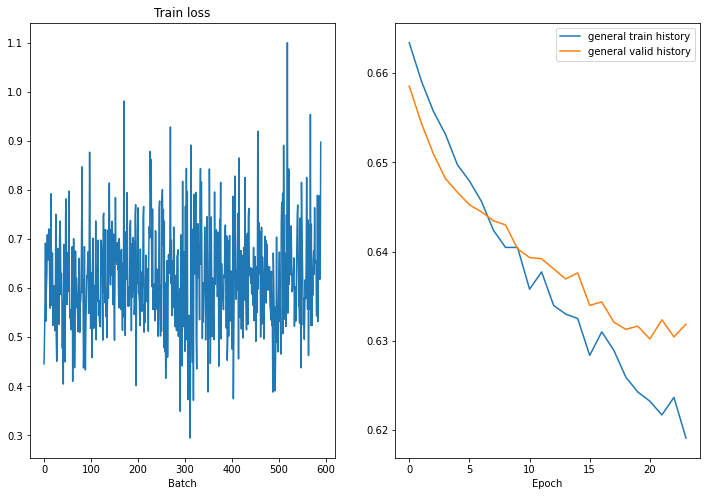

Test (accuracy, f1):  (0.651294498381877, 0.7515885453666562)


In [ ]:
n_epochs = 100
bert = model_class.from_pretrained(pretrained_weights).to(device)
model = BertQA4(bert, dropout=0.5, hid_size=(2048, 1024, 512)).to(device)
freeze(model)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()

train_epochs (model, train_loader, valid_loader,optimizer, criterion, scheduler=None, CLIP=1, N_EPOCHS=n_epochs, patience=3) 
print("Test (accuracy, f1): ", test(model))

Результат - 0.6513

Дообучим модель полностью, включая слои БЕРТа.

In [ ]:
model = BertQA4(bert, dropout=0.2, hid_size=(2048, 1024, 512)).to(device)
model.load_state_dict(torch.load('best-val-model.pt'))
freeze(model, flag=True)

Params to learn:
	 bert.embeddings.word_embeddings.weight
	 bert.embeddings.position_embeddings.weight
	 bert.embeddings.token_type_embeddings.weight
	 bert.embeddings.LayerNorm.weight
	 bert.embeddings.LayerNorm.bias
	 bert.encoder.layer.0.attention.self.query.weight
	 bert.encoder.layer.0.attention.self.query.bias
	 bert.encoder.layer.0.attention.self.key.weight
	 bert.encoder.layer.0.attention.self.key.bias
	 bert.encoder.layer.0.attention.self.value.weight
	 bert.encoder.layer.0.attention.self.value.bias
	 bert.encoder.layer.0.attention.output.dense.weight
	 bert.encoder.layer.0.attention.output.dense.bias
	 bert.encoder.layer.0.attention.output.LayerNorm.weight
	 bert.encoder.layer.0.attention.output.LayerNorm.bias
	 bert.encoder.layer.0.intermediate.dense.weight
	 bert.encoder.layer.0.intermediate.dense.bias
	 bert.encoder.layer.0.output.dense.weight
	 bert.encoder.layer.0.output.dense.bias
	 bert.encoder.layer.0.output.LayerNorm.weight
	 bert.encoder.layer.0.output.LayerNorm.bia

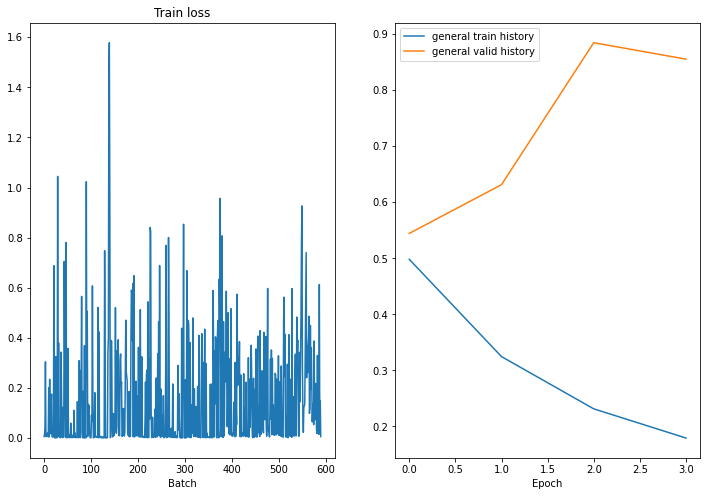

Test (accuracy, f1):  (0.7224919093851133, 0.7767383149206738)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.BCELoss()

train_epochs (model, train_loader, valid_loader,optimizer, criterion, scheduler=None, CLIP=1, N_EPOCHS=n_epochs, patience=3) 
print("Test (accuracy, f1): ", test(model))

Результат - 0.7225. Во время экспериментов на данной архитектуре был достигнут результат 0.7389.

 Проверим эту модель на наших примерах.

In [ ]:
def predict (model, questions, passages, weights='best-val-model.pt'):

    model.load_state_dict(torch.load(weights))
    model.eval()
    for i in range(len(questions)):
        text = tokenizer.encode(questions[i], passages[i], add_special_tokens=True)
        sep_index = text.index(tokenizer.sep_token_id)
        num_seg_a = sep_index + 1
        num_seg_b = len(text) - num_seg_a
        segment_ids = [0]*num_seg_a + [1]*num_seg_b
        text = torch.LongTensor(text).unsqueeze(0)
        segment_ids = torch.LongTensor(segment_ids).unsqueeze(0)
        attention_mask = torch.ones_like(text)

        with torch.no_grad():
            inputs = text.to(device)
            attention_mask = attention_mask.to(device)
            segment_ids = segment_ids.to(device)
            output = model(inputs, attention_mask, segment_ids).squeeze(1).squeeze(0).cpu().detach().numpy() > 0.5   

        print("Q.: ", questions[i])
        # print("P.: ", passage[i])
        if output:
            print ('YES')
        else:
            print('NO')

In [ ]:
predict (model, test_questions, test_passages, weights='best-val-model.pt')

Q.:  is manic depression the same as bi polar
NO
Q.:  was whiskey galore based on a true story
YES
Q.:  are there plants on the international space station
YES
Q.:  does the hockey puck have to cross the line to be a goal
NO
Q.:  will there be a season 5 of shadowhunters
NO


Эта модель работает немного лучше на конкретных примерах, и её качество соответствует тому, что мы видим на примерах.

Теперь попробуем обучить модель сразу всю.

In [ ]:
bert = model_class.from_pretrained(pretrained_weights).to(device)
model = BertQA4(bert, dropout=0.5, hid_size=(2048, 1024, 512)).to(device)
freeze(model, flag=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Params to learn:
	 bert.embeddings.word_embeddings.weight
	 bert.embeddings.position_embeddings.weight
	 bert.embeddings.token_type_embeddings.weight
	 bert.embeddings.LayerNorm.weight
	 bert.embeddings.LayerNorm.bias
	 bert.encoder.layer.0.attention.self.query.weight
	 bert.encoder.layer.0.attention.self.query.bias
	 bert.encoder.layer.0.attention.self.key.weight
	 bert.encoder.layer.0.attention.self.key.bias
	 bert.encoder.layer.0.attention.self.value.weight
	 bert.encoder.layer.0.attention.self.value.bias
	 bert.encoder.layer.0.attention.output.dense.weight
	 bert.encoder.layer.0.attention.output.dense.bias
	 bert.encoder.layer.0.attention.output.LayerNorm.weight
	 bert.encoder.layer.0.attention.output.LayerNorm.bias
	 bert.encoder.layer.0.intermediate.dense.weight
	 bert.encoder.layer.0.intermediate.dense.bias
	 bert.encoder.layer.0.output.dense.weight
	 bert.encoder.layer.0.output.dense.bias
	 bert.encoder.layer.0.output.LayerNorm.weight
	 bert.encoder.layer.0.output.LayerNorm.bia

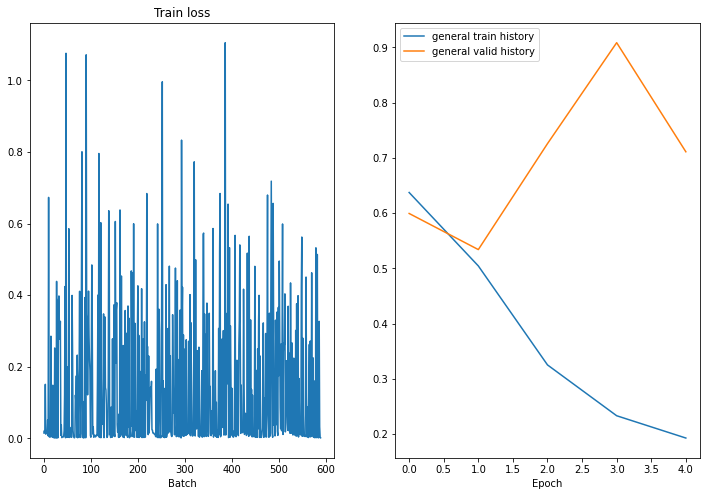

Test (accuracy, f1):  (0.723705501618123, 0.7836736271684391)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.BCELoss()

train_epochs (model, train_loader, valid_loader,optimizer, criterion, scheduler=None, CLIP=1, N_EPOCHS=n_epochs, patience=3) 
print("Test (accuracy, f1): ", test(model))

Результат - 0.7237.

Во время экспериментов лучшее качество неизменно давал вариант с обучением сначала полносвязных слоёв, а потом - дообучением всеё модели. При прогоне отчета ситуация изменилася, но отличие в качестве при полном файнтьюнинге модели сразу не сильно выше поэтапного варианта. 

Проделаем то же самое, заменив БЕРТ на **roBERTa**

In [ ]:
# ROBERTA
model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-base')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert = model_class.from_pretrained(pretrained_weights).to(device)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Изменим немного форвард - в роБЕРТу не передаем разметку сегментов текста.

In [ ]:
class BertQA6(nn.Module):
    def __init__(self, pretrained_model, dropout=0.1, hid_size=(1024, 1024, 1024), dim=768):
        super().__init__()
        
        self.dim = dim
        self.hid_size = hid_size

        self.bert = pretrained_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.pre_classifier1 = nn.Linear(self.dim, self.hid_size[0])
        self.pre_classifier2 = nn.Linear(self.hid_size[0], self.hid_size[1])
        self.pre_classifier3 = nn.Linear(self.hid_size[1], self.hid_size[2])
        self.classifier = nn.Linear(self.hid_size[2], 1)

    
    def forward(self, inputs, attention_mask, segment_ids):
        outputs = self.bert(inputs, attention_mask=attention_mask)
        hidden_state = outputs[0]
        features = hidden_state[:, 0]
        
        features = self.pre_classifier1(features)
        features = self.relu(features)
        features = self.dropout(features)
        
        features = self.pre_classifier2(features)
        features = self.relu(features)
        
        features = self.pre_classifier3(features)
        features = self.relu(features)
        
        
        logits = self.classifier(features)
        
        proba = self.sigmoid(logits)

        
        return proba

In [ ]:
train_data = QADataset2(train_data_df['passage'], train_data_df['question'], train_data_df['answer'],  tokenizer)
dev_data = QADataset2(dev_data_df['passage'], dev_data_df['question'], dev_data_df['answer'],  tokenizer)

train_data = Subset(train_data, range(len(train_data)))
val_size = int(.5 * len(dev_data)) 
valid_data, test_data = random_split(dev_data, [val_size, len(dev_data) - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (899 > 512). Running this sequence through the model will result in indexing errors


Number of training examples: 9427
Number of validation examples: 1635
Number of testing examples: 1635


In [ ]:
batch_size = 16 #64
train_loader = DataLoader(train_data, batch_sampler=QASampler(train_data, batch_size=batch_size), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=QASampler(valid_data, batch_size=batch_size), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=QASampler(test_data, batch_size=batch_size), collate_fn=collate_fn)

Как и в случае с БЕРТом, применим двухэтапное обучение-дообучение.

In [ ]:
bert = model_class.from_pretrained(pretrained_weights).to(device)
model = BertQA6(bert, dropout=0.5, hid_size=(2048, 1024, 512)).to(device)
model_structure(model)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert:
      embeddings:
                  word_embeddings
                  position_embeddings
                  token_type_embeddings
                  LayerNorm
                  dropout
      encoder:
               layer:
                      0:
                         attention:
                                    self:
                                          query
                                          key
                                          value
                                          dropout
                                    output:
                                            dense
                                            LayerNorm
                                            dropout
                         intermediate:
                                       dense
                         output:
                                 dense
                                 LayerNorm
                                 dropout
                      1:
             

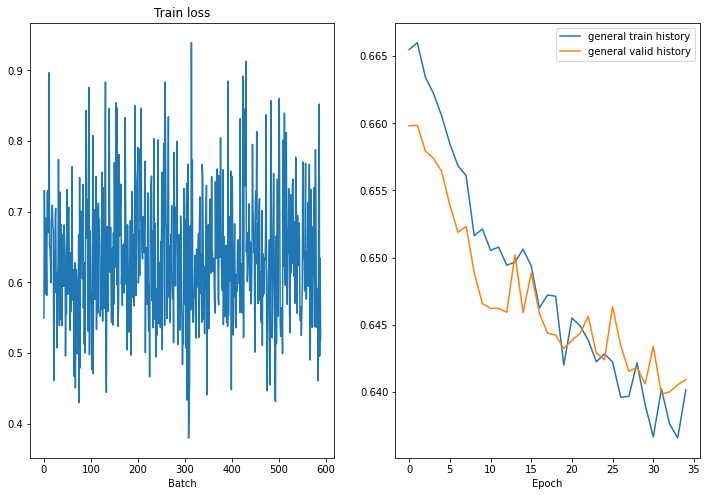

Test (accuracy, f1):  (0.6270226537216828, 0.7451878863261421)


In [ ]:
freeze(model)
n_epochs = 50

optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.BCELoss()
train_epochs (model, train_loader, valid_loader,optimizer, criterion, scheduler=None, CLIP=1, N_EPOCHS=n_epochs, patience=3) 
print("Test (accuracy, f1): ", test(model, iterator=test_loader))

Результат - 0.6270

In [ ]:
model = BertQA6(bert, dropout=0.2, hid_size=(2048, 1024, 512)).to(device)
model.load_state_dict(torch.load('best-val-model.pt'))
freeze(model, flag=True)

Params to learn:
	 bert.embeddings.word_embeddings.weight
	 bert.embeddings.position_embeddings.weight
	 bert.embeddings.token_type_embeddings.weight
	 bert.embeddings.LayerNorm.weight
	 bert.embeddings.LayerNorm.bias
	 bert.encoder.layer.0.attention.self.query.weight
	 bert.encoder.layer.0.attention.self.query.bias
	 bert.encoder.layer.0.attention.self.key.weight
	 bert.encoder.layer.0.attention.self.key.bias
	 bert.encoder.layer.0.attention.self.value.weight
	 bert.encoder.layer.0.attention.self.value.bias
	 bert.encoder.layer.0.attention.output.dense.weight
	 bert.encoder.layer.0.attention.output.dense.bias
	 bert.encoder.layer.0.attention.output.LayerNorm.weight
	 bert.encoder.layer.0.attention.output.LayerNorm.bias
	 bert.encoder.layer.0.intermediate.dense.weight
	 bert.encoder.layer.0.intermediate.dense.bias
	 bert.encoder.layer.0.output.dense.weight
	 bert.encoder.layer.0.output.dense.bias
	 bert.encoder.layer.0.output.LayerNorm.weight
	 bert.encoder.layer.0.output.LayerNorm.bia

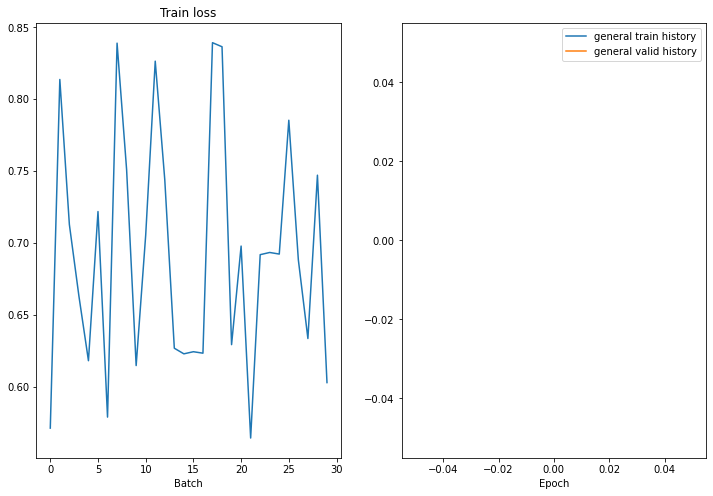

KeyboardInterrupt: 

In [ ]:
n_epochs = 5
optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.BCELoss()

train_epochs (model, train_loader, valid_loader,optimizer, criterion, scheduler=None, CLIP=1, N_EPOCHS=n_epochs, patience=3) 
print("Test (accuracy, f1): ", test(model, iterator=test_loader))

Обучение было прервано после 5 эпох.

In [ ]:
print("Test (accuracy, f1): ", test(model, iterator=test_loader))

Test (accuracy, f1):  (0.6134708737864077, 0.7502807519844225)


Результат дообучения -0.6135, что даже хуже обучения только классифицирующих слоев.

Таким образом, в этой части лучшее качество (0.72) дало использование BERT.